In [1]:
import xarray as xr
import numpy as np
import gdal

In [2]:
ds = xr.open_dataset("D:\\EOData\\DCS4COP\\S2Plus\\DCS4COP_S2A_0021_FLANDERS_20180802T105621Z_31UCS_V003.nc")

In [3]:
ds

<xarray.Dataset>
Dimensions:                       (x: 10980, y: 10980)
Coordinates:
  * x                             (x) float64 3e+05 3e+05 ... 4.098e+05
  * y                             (y) float64 5.7e+06 5.7e+06 ... 5.59e+06
    lon                           (y, x) float32 ...
    lat                           (y, x) float32 ...
Data variables:
    transverse_mercator           int32 ...
    rrs_443                       (y, x) float32 ...
    rrs_490                       (y, x) float32 ...
    rrs_560                       (y, x) float32 ...
    rrs_665                       (y, x) float32 ...
    rrs_705                       (y, x) float32 ...
    rrs_740                       (y, x) float32 ...
    rrs_783                       (y, x) float32 ...
    rrs_842                       (y, x) float32 ...
    rrs_865                       (y, x) float32 ...
    rrs_1610                      (y, x) float32 ...
    rrs_2190                      (y, x) float32 ...
    TUR_NECHAD2009_

In [4]:
ds.x

<xarray.DataArray 'x' (x: 10980)>
array([300005., 300015., 300025., ..., 409775., 409785., 409795.])
Coordinates:
  * x        (x) float64 3e+05 3e+05 3e+05 ... 4.098e+05 4.098e+05 4.098e+05
Attributes:
    units:          m
    standard_name:  projection_x_coordinate

In [5]:
ds.Kd_560

<xarray.DataArray 'Kd_560' (y: 10980, x: 10980)>
[120560400 values with dtype=float32]
Coordinates:
  * x        (x) float64 3e+05 3e+05 3e+05 ... 4.098e+05 4.098e+05 4.098e+05
  * y        (y) float64 5.7e+06 5.7e+06 5.7e+06 ... 5.59e+06 5.59e+06 5.59e+06
    lon      (y, x) float32 ...
    lat      (y, x) float32 ...
Attributes:
    standard_name:  diffuse_attenuation_coefficient_of_downwelling_radiative_...
    long_name:      Diffuse attenuation coefficient at 560 nm, KD2 algorithm
    units:          m-1
    grid_mapping:   transverse_mercator

In [6]:
ds.Kd_560.encoding

{'zlib': True,
 'shuffle': True,
 'complevel': 4,
 'fletcher32': False,
 'contiguous': False,
 'chunksizes': (1373, 1373),
 'source': 'D:\\EOData\\DCS4COP\\S2Plus\\DCS4COP_S2A_0021_FLANDERS_20180802T105621Z_31UCS_V003.nc',
 'original_shape': (10980, 10980),
 'dtype': dtype('int16'),
 '_FillValue': 32767,
 'scale_factor': 0.01,
 'add_offset': 327.68,
 'coordinates': 'lat lon'}

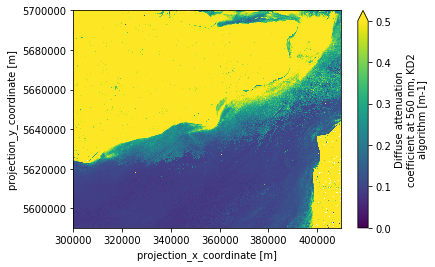

In [23]:
ds.Kd_560.plot.imshow(vmin=0., vmax=.5)

In [8]:
CRS_WKT_EPSG_4326 = """
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.01745329251994328,
        AUTHORITY["EPSG","9122"]],
    AUTHORITY["EPSG","4326"]]
"""

In [9]:
ds.transverse_mercator

<xarray.DataArray 'transverse_mercator' ()>
array(-2147483647)
Attributes:
    grid_mapping_name:                 transverse_mercator
    scale_factor_at_central_meridian:  0.9996
    longitude_of_central_meridian:     3.0
    latitude_of_projection_origin:     0.0
    false_easting:                     500000.0
    false_northing:                    0.0
    semi_major_axis:                   6378137.0
    inverse_flattening:                298.257223563

In [10]:
CRS_WKT_S2 = """
PROJCS["Some Sentinel-2 UTM Tile",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG",7030]],
            TOWGS84[0,0,0,0,0,0,0],
            AUTHORITY["EPSG",6326]],
        PRIMEM["Greenwich",0,AUTHORITY["EPSG",8901]],
        UNIT["DMSH",0.0174532925199433,AUTHORITY["EPSG",9108]],
        AXIS["Lat",NORTH],
        AXIS["Long",EAST],
        AUTHORITY["EPSG",4326]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0.0],
    PARAMETER["central_meridian",3.0],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000.0],
    PARAMETER["false_northing",0.0]]
"""

In [11]:
ds.x.values

array([300005., 300015., 300025., ..., 409775., 409785., 409795.])

In [12]:
ds.y.values

array([5699995., 5699985., 5699975., ..., 5590225., 5590215., 5590205.])

See http://www.gdal.org/structGDALWarpOptions.html

In [13]:
def reproject_to_wgs84(src_var):
    src_width = src_var.shape[-1]
    src_height = src_var.shape[-2]
    
    src_x1 = float(src_var.x[0])
    src_x2 = float(src_var.x[-1])
    src_y1 = float(src_var.y[0])
    src_y2 = float(src_var.y[-1])
    src_res = (src_x2 - src_x1) / (src_width - 1)
    src_geo_transform = (src_x1, src_res, 0.0,
                         src_y2, 0.0, -src_res)
    
    mem_driver = gdal.GetDriverByName("MEM")
    src_ds = mem_driver.Create('src_' + src_var.name, src_width, src_height, 1, gdal.GDT_Float32, [])    
    src_ds.SetProjection(CRS_WKT_S2)
    src_ds.SetGeoTransform(src_geo_transform)
    src_ds.GetRasterBand(1).SetNoDataValue(float('nan'))
    src_ds.GetRasterBand(1).WriteArray(src_var.values)

    dst_x1_0 = float(src_var.lon[0][0])
    dst_x2_0 = float(src_var.lon[0][-1])
    dst_y1_0 = float(src_var.lat[0][0])
    dst_y2_0 = float(src_var.lat[-1][0])
    dst_x1 = min(dst_x1_0, dst_x2_0)
    dst_x2 = max(dst_x1_0, dst_x2_0)
    dst_y1 = min(dst_y1_0, dst_y2_0)
    dst_y2 = max(dst_y1_0, dst_y2_0)
    print("dst_bbox: ", dst_x1, dst_y1, dst_x2, dst_y2)
    dst_res_x = (dst_x2 - dst_x1) / (src_width - 1)
    dst_res_y = (dst_y2 - dst_y1) / (src_height - 1)    
    dst_res = min(dst_res_x, dst_res_y)
    print("dst_res:", dst_res_x, dst_res_y, dst_res)
    dst_width = int((dst_x2 - dst_x1) / dst_res + 0.5)
    dst_res = (dst_x2 - dst_x1) / dst_width
    dst_height = int((dst_y2 - dst_y1) / dst_res + 0.5)    
    print("dst_size:", dst_width, dst_height)
    dst_geo_transform = (dst_x1 - dst_res / 2, dst_res, 0.0,
                         dst_y1 - dst_res / 2, 0.0, -dst_res)
    print("dst_geo_transform:", dst_geo_transform)
    # correct actual
    dst_x2 = dst_x1 + dst_res * (dst_width - 1)
    dst_y2 = dst_y1 + dst_res * (dst_height - 1)

    dst_ds = mem_driver.Create('dst_' + src_var.name, dst_width, dst_height, 1, gdal.GDT_Float32, [])
    dst_ds.SetProjection(CRS_WKT_EPSG_4326)
    dst_ds.SetGeoTransform(dst_geo_transform)
    dst_ds.GetRasterBand(1).SetNoDataValue(float('nan'))

    resample_alg = gdal.GRA_NearestNeighbour
    warp_mem_limit = 0
    error_threshold = 0
    options = ['INIT_DEST=NO_DATA']
    gdal.ReprojectImage(src_ds,
                        dst_ds,
                        None, # src_wkt
                        None, # dst_wkt
                        resample_alg,
                        warp_mem_limit,
                        error_threshold,
                        None,  # callback,
                        None,  # callback_data,
                        options)
    
    dst_values = dst_ds.GetRasterBand(1).ReadAsArray()
    
    dst_var = xr.DataArray(dst_values, 
                           dims=['lat', 'lon'], 
                           name=src_var.name, 
                           attrs=dict(**src_var.attrs), 
                           coords=dict(lat=np.linspace(dst_y2, dst_y1 - dst_res, dst_height),
                                       lon=np.linspace(dst_x1, dst_x2 + dst_res, dst_width)))
    
    return dst_var

In [14]:
kd_560_proj = reproject_to_wgs84(ds.Kd_560)

dst_bbox:  0.12378285825252533 50.42975997924805 1.7020214796066284 51.41584014892578
dst_res: 0.0001437506714048732 8.9815117012272e-05 8.9815117012272e-05
dst_size: 17572 10979
dst_geo_transform: (0.12373795048387765, 8.981553729536211e-05, 0.0, 50.4297150714794, 0.0, -8.981553729536211e-05)


In [15]:
kd_560_proj

<xarray.DataArray 'Kd_560' (lat: 10979, lon: 17572)>
array([[     nan,      nan,      nan, ..., 0.51001 , 0.480011, 0.480011],
       [     nan,      nan,      nan, ..., 0.5     , 0.480011, 0.480011],
       [     nan,      nan,      nan, ..., 0.480011, 0.48999 , 0.48999 ],
       ...,
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan]],
      dtype=float32)
Coordinates:
  * lat      (lat) float64 51.42 51.42 51.42 51.42 ... 50.43 50.43 50.43 50.43
  * lon      (lon) float64 0.1238 0.1239 0.124 0.1241 ... 1.702 1.702 1.702
Attributes:
    standard_name:  diffuse_attenuation_coefficient_of_downwelling_radiative_...
    long_name:      Diffuse attenuation coefficient at 560 nm, KD2 algorithm
    units:          m-1
    grid_mapping:   transverse_mercator

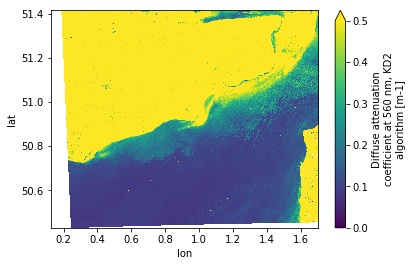

In [16]:
kd_560_proj.plot.imshow(vmin=0., vmax=.5)

In [17]:
subs = ds.isel(y=slice(1000, 1005), x=slice(1000, 1005))

In [18]:
subs

<xarray.Dataset>
Dimensions:                       (x: 5, y: 5)
Coordinates:
  * x                             (x) float64 3.1e+05 3.1e+05 ... 3.1e+05
  * y                             (y) float64 5.69e+06 5.69e+06 ... 5.69e+06
    lon                           (y, x) float32 ...
    lat                           (y, x) float32 ...
Data variables:
    transverse_mercator           int32 -2147483647
    rrs_443                       (y, x) float32 ...
    rrs_490                       (y, x) float32 ...
    rrs_560                       (y, x) float32 ...
    rrs_665                       (y, x) float32 ...
    rrs_705                       (y, x) float32 ...
    rrs_740                       (y, x) float32 ...
    rrs_783                       (y, x) float32 ...
    rrs_842                       (y, x) float32 ...
    rrs_865                       (y, x) float32 ...
    rrs_1610                      (y, x) float32 ...
    rrs_2190                      (y, x) float32 ...
    TUR_NECHAD2

In [19]:
subs.rrs_443

<xarray.DataArray 'rrs_443' (y: 5, x: 5)>
array([[0.014   , 0.014   , 0.016998, 0.016998, 0.016998],
       [0.014   , 0.014   , 0.016998, 0.016998, 0.016998],
       [0.019001, 0.019001, 0.016998, 0.016998, 0.016998],
       [0.019001, 0.019001, 0.016998, 0.016998, 0.016998],
       [0.019001, 0.019001, 0.016998, 0.016998, 0.016998]], dtype=float32)
Coordinates:
  * x        (x) float64 3.1e+05 3.1e+05 3.1e+05 3.1e+05 3.1e+05
  * y        (y) float64 5.69e+06 5.69e+06 5.69e+06 5.69e+06 5.69e+06
    lon      (y, x) float32 ...
    lat      (y, x) float32 ...
Attributes:
    standard_name:  surface_ratio_of_upwelling_radiance_emerging_from_sea_wat...
    long_name:      sea surface reflectance defined as the ration of water-le...
    units:          sr-1
    grid_mapping:   transverse_mercator

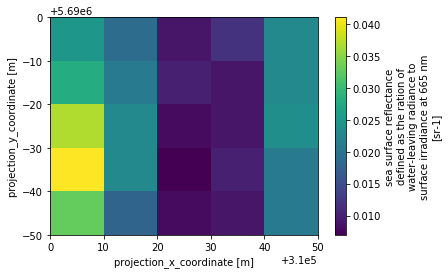

In [20]:
subs.rrs_665.plot.imshow()

In [21]:
subs_proj = reproject_to_wgs84(subs.rrs_665)

dst_bbox:  0.2727627754211426 51.3291015625 0.273336261510849 51.329463958740234
dst_res: 0.00014337152242660522 9.059906005859375e-05 9.059906005859375e-05
dst_size: 6 4
dst_geo_transform: (0.272714984913667, 9.558101495107015e-05, 0.0, 51.32905377199253, 0.0, -9.558101495107015e-05)


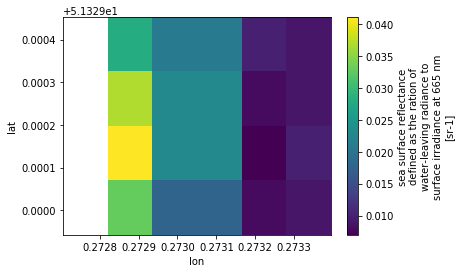

In [22]:
subs_proj.plot.imshow()